# Many model comparison

This notebook piggybacks off off the [cartesian infrastructure](https://github.com/matsengrp/torchdms-experiments/tree/master/tdmsex/scripts) for training `torchdms` models. It collects all the models into a descriptive dataframe, and then predicts on the octet data from the victora lab. Here, we are predicting on higher-order, higher affinity mutants to find possible causes for "the wall" (i.e. models _stochastically_ seem to have a ceiling on predicting phenotypes - and it depends mostly on the seed). While we're targetting the octet dataset, this same infrastructure could be used for hyper-parameter tuning and testing for model consistany in other contexts, as well.

In [144]:
import pickle
import json
import os
import sys
from functools import reduce
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import torch
from Bio.Seq import Seq
from Bio import SeqIO
import binarymap
import glob
import gctree

from plotnine import *
import matplotlib.pyplot as plt
%matplotlib inline

## Which experiments to compare?

In [145]:
data_dir = "../nextflow/data/torchdms/raw-dms"
prepped_dir = "../nextflow/data/torchdms/prepped-dms"
pos_csv_path = "https://raw.githubusercontent.com/jbloomlab/Ab-CGGnaive_DMS/main/data/CGGnaive_sites.csv"
octet_data_path = f"{prepped_dir}/calibrated-octet-data.csv"

exp_rhino_path = "/home/jgallowa/Projects/torchdms/torchdms-experiments/experiments"
# models_dir = "calibrated_octet_models"
models_dir = "2022-05-22-CGG-bind-stab-poly"
exps = [
    "2022-05-22-CGG-bind-stab-poly"
]

In [146]:
# ! rm -rf {models_dir}

## `rsync` all .model files

In [147]:
for exp in exps:
    ! rsync -v -a -m --include='**/*.model' --include='*/' --include='**/*.csv' --exclude='*' --ignore-existing \
        jgallowa@rhino.fhcrc.org:{exp_rhino_path}/{exp}/_output {exp}

receiving file list ... done
created directory 2022-05-22-CGG-bind-stab-poly
_output/
_output/loss_fn@huber/
_output/loss_fn@huber/model_string@FullyConnected;[2_6];[None_'relu']/
_output/loss_fn@huber/model_string@FullyConnected;[2_6];[None_'relu']/seed@0/
_output/loss_fn@huber/model_string@FullyConnected;[2_6];[None_'relu']/seed@0/CGG-bind-stab-poly.error-summary.csv
_output/loss_fn@huber/model_string@FullyConnected;[2_6];[None_'relu']/seed@0/CGG-bind-stab-poly.error.csv
_output/loss_fn@huber/model_string@FullyConnected;[2_6];[None_'relu']/seed@0/CGG-bind-stab-poly.model
_output/loss_fn@huber/model_string@FullyConnected;[2_6];[None_'relu']/seed@0/CGG-bind-stab-poly.scatter.corr.csv
_output/loss_fn@huber/model_string@FullyConnected;[2_6];[None_'relu']/seed@1/
_output/loss_fn@huber/model_string@FullyConnected;[2_6];[None_'relu']/seed@1/CGG-bind-stab-poly.error-summary.csv
_output/loss_fn@huber/model_string@FullyConnected;[2_6];[None_'relu']/seed@1/CGG-bind-stab-poly.error.csv
_output/l

_output/loss_fn@l1/model_string@Linear/seed@2/CGG-bind-stab-poly.scatter.corr.csv
_output/loss_fn@l1/model_string@Linear/seed@3/
_output/loss_fn@l1/model_string@Linear/seed@3/CGG-bind-stab-poly.error-summary.csv
_output/loss_fn@l1/model_string@Linear/seed@3/CGG-bind-stab-poly.error.csv
_output/loss_fn@l1/model_string@Linear/seed@3/CGG-bind-stab-poly.model
_output/loss_fn@l1/model_string@Linear/seed@3/CGG-bind-stab-poly.scatter.corr.csv
_output/loss_fn@l1/model_string@Linear/seed@4/
_output/loss_fn@l1/model_string@Linear/seed@4/CGG-bind-stab-poly.error-summary.csv
_output/loss_fn@l1/model_string@Linear/seed@4/CGG-bind-stab-poly.error.csv
_output/loss_fn@l1/model_string@Linear/seed@4/CGG-bind-stab-poly.model
_output/loss_fn@l1/model_string@Linear/seed@4/CGG-bind-stab-poly.scatter.corr.csv
_output/loss_fn@mse/
_output/loss_fn@mse/model_string@FullyConnected;[2_6];[None_'relu']/
_output/loss_fn@mse/model_string@FullyConnected;[2_6];[None_'relu']/seed@0/
_output/loss_fn@mse/model_string@Ful

In [148]:
! tree -L 3 {exp}/

2022-05-22-CGG-bind-stab-poly/
└── _output
    ├── loss_fn@huber
    │   ├── model_string@FullyConnected;[2_6];[None_'relu']
    │   └── model_string@Linear
    ├── loss_fn@l1
    │   ├── model_string@FullyConnected;[2_6];[None_'relu']
    │   └── model_string@Linear
    └── loss_fn@mse
        ├── model_string@FullyConnected;[2_6];[None_'relu']
        └── model_string@Linear

10 directories, 0 files


## Collect all models into a descriptive df

In [149]:
# collect the models
models = defaultdict(list)
for i, path in enumerate(glob.glob(f'{models_dir}/**/*.model', recursive=True)):
    dir_struct = path.split("/")
    models["model_name"].append(dir_struct[-1])
    models["model"].append(torch.load(path, map_location="cpu"))
    for des in dir_struct[2:-1]:
        # hack
        if des.startswith("monotonic"): continue
        param, value = des.split("@")
        models[param].append(value)

model_df = pd.DataFrame(models)
model_df = model_df.assign(model_id=range(len(model_df)))
model_df

,model_name,model,loss_fn,model_string,seed,model_id
0,CGG-bind-stab-poly.model,Linear(\n (latent_layer): Linear(in_features=...,mse,Linear,2,0
1,CGG-bind-stab-poly.model,Linear(\n (latent_layer): Linear(in_features=...,mse,Linear,4,1
2,CGG-bind-stab-poly.model,Linear(\n (latent_layer): Linear(in_features=...,mse,Linear,0,2
3,CGG-bind-stab-poly.model,Linear(\n (latent_layer): Linear(in_features=...,mse,Linear,3,3
4,CGG-bind-stab-poly.model,Linear(\n (latent_layer): Linear(in_features=...,mse,Linear,1,4
5,CGG-bind-stab-poly.model,FullyConnected(\n (latent_layer): Linear(in_f...,mse,FullyConnected;[2_6];[None_'relu'],2,5
6,CGG-bind-stab-poly.model,FullyConnected(\n (latent_layer): Linear(in_f...,mse,FullyConnected;[2_6];[None_'relu'],4,6
7,CGG-bind-stab-poly.model,FullyConnected(\n (latent_layer): Linear(in_f...,mse,FullyConnected;[2_6];[None_'relu'],0,7
8,CGG-bind-stab-poly.model,FullyConnected(\n (latent_layer): Linear(in_f...,mse,FullyConnected;[2_6];[None_'relu'],3,8
9,CGG-bind-stab-poly.model,FullyConnected(\n (latent_layer): Linear(in_f...,mse,FullyConnected;[2_6];[None_'relu'],1,9


In [150]:
model_df.loc[5, "model"]

FullyConnected(
  (latent_layer): Linear(in_features=4935, out_features=2, bias=False)
  (nonlinearity_1): Linear(in_features=2, out_features=6, bias=False)
  (output_layer): Linear(in_features=6, out_features=3, bias=False)
)

In [151]:
# ind_models = [idx for idx, row in model_df.iterrows() if row.model_string.startswith("Independent")]
# ind_model = model_df.loc[ind_models[0], "model"]

In [152]:
# ind_model

In [153]:
# for mp in model_df.loc[0, "model"].monotonic_params_from_latent_space():
#     print(mp)
#     print()

In [154]:
# print("\n".join(model_df.model_string.unique()))
# to_drop = [idx for idx, row in model_df.iterrows() if row.model_string.startswith("Independent")]
# model_df = model_df.drop(to_drop)

In [155]:
# print("\n".join(model_df.model_string.unique()))

In [156]:
! ls ../nextflow/data/torchdms/

misc-dms  prepped-dms  raw-dms


## Collect final variant scores

In [157]:
final_multi_variant_scores = pd.read_csv(f"{prepped_dir}/final-multi-variant-scores.csv")
final_multi_variant_scores

,aa_substitutions,aa_substitutions_IMGT,tdms_strata,aa_sequence,delta_bind,delta_stab,delta_poly,bind,stab,poly,library,unseen_mutations,split_set,n_aa_substitutions
0,A91T T132L,A100(H)T T5(L)L,2,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,-1.120389,-1.225703,1.614845,9.321501,9.220537,8.631975,dms,False,test,2
1,A96T D98S,A105(H)T D107(H)S,2,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,-0.583298,0.062470,0.589685,9.858592,10.508710,7.606815,dms,False,test,2
2,C150W E208C,C23(L)W E97(L)C,2,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,-1.318972,-2.448595,1.309087,9.122918,7.997645,8.326217,dms,False,test,2
3,C22H S134R G143P,C23(H)H S7(L)R G16(L)P,3,EVQLQESGPSLVKPSQTLSLTHSVTGDSITSGYWNWIRKFPGNKLE...,NaN,-3.872965,1.305743,NaN,6.573275,8.322873,dms,False,test,3
4,C22N S28T I233T,C23(H)N S29(H)T I126(L)T,3,EVQLQESGPSLVKPSQTLSLTNSVTGDTITSGYWNWIRKFPGNKLE...,-1.070922,-1.750284,0.657205,9.370968,8.695956,7.674335,dms,False,test,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16715,A161G Y163F A173S N219Y,A40(L)G Y42(L)F A52(L)S N108(L)Y,3,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,2.562305,NaN,NaN,9.492144,NaN,NaN,octet,NaN,train,4
16716,A161G Y163F A173S Q216H N219Y,A40(L)G Y42(L)F A52(L)S Q105(L)H N108(L)Y,3,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,2.690806,NaN,NaN,9.583359,NaN,NaN,octet,NaN,train,5
16717,A161G Y163F A173S N219S,A40(L)G Y42(L)F A52(L)S N108(L)S,3,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,2.423506,NaN,NaN,9.393619,NaN,NaN,octet,NaN,train,4
16718,A161G Y163F A173S Q216H N219S,A40(L)G Y42(L)F A52(L)S Q105(L)H N108(L)S,3,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,2.428066,NaN,NaN,9.396856,NaN,NaN,octet,NaN,train,5


## Parse octet data

In [158]:
octet_df = final_multi_variant_scores.query("library == 'octet'").reset_index().copy()
id_vars = [
    "aa_sequence", "n_aa_substitutions","aa_substitutions_IMGT", "aa_substitutions", "delta_bind", "split_set"
]
octet_df = octet_df[id_vars]
octet_df

,aa_sequence,n_aa_substitutions,aa_substitutions_IMGT,aa_substitutions,delta_bind,split_set
0,EVQLQESGPSLVKPSQTLSLTCSVTGASITSGYWNWIRKFPGNRLE...,8,D28(H)A K49(H)R S64(H)G A40(L)G Y42(L)F A52(L)...,D27A K44R S56G A161G Y163F A173S Q216H N219Y,3.572199,test
1,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,1,A40(L)G,A161G,0.989529,train
2,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,1,A40(L)V,A161V,-0.571533,train
3,EVQLQESGPSLVKPSQTLSLTCSVTGASITSGYWNWIRKFPGNKLE...,1,D28(H)A,D27A,1.050609,train
4,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRRFPGNKLE...,1,K44(H)R,K39R,-0.030445,train
5,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNRLE...,1,K49(H)R,K44R,-0.010932,train
6,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,1,Y42(L)F,Y163F,-0.041322,train
7,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,1,A52(L)S,A173S,0.747789,train
8,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,1,Y55(L)F,Y176F,0.237139,train
9,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,1,N108(L)S,N219S,0.216255,train


## Predict octet data points with every model

In [159]:
# now add all model predictions
# just bind for now
model_pred = {}
for idx, row in model_df.iterrows():
    model_pred[row.model_id] = [
#         row.model(row.model.seq_to_binary("".join(aa_seq))).detach().numpy()[0]
        row.model(row.model.seq_to_binary(aa_seq)).detach().numpy()[0]
        for aa_seq in octet_df.aa_sequence.values
    ]


In [160]:
model_pred

{0: [3.4947824,
  0.69327307,
  -0.9517083,
  0.37037444,
  -0.34043097,
  -0.2309928,
  0.026680589,
  0.10511887,
  -0.024810672,
  0.32632816,
  -0.3036214,
  0.47489542,
  -0.7473395,
  -0.44389462,
  -1.2986269,
  0.5716952,
  1.1790439,
  3.385344,
  3.5547724,
  2.0924911,
  1.5744237,
  -0.7477293,
  2.5012317,
  2.5980315,
  2.3526645,
  2.4494643,
  2.5220928],
 1: [3.4866557,
  0.6743812,
  -0.97507864,
  0.3528396,
  -0.36258948,
  -0.25050688,
  0.00809443,
  0.08126223,
  -0.036426544,
  0.3073191,
  -0.325949,
  0.45705026,
  -0.75994855,
  -0.4735844,
  -1.3117318,
  0.55439675,
  1.1694504,
  3.3745735,
  3.547362,
  2.0834632,
  1.5658079,
  -0.7565476,
  2.4906745,
  2.5880208,
  2.3409433,
  2.4382896,
  2.513732],
 2: [3.5374064,
  0.676818,
  -0.9669707,
  0.35530865,
  -0.36379576,
  -0.24706364,
  0.039471388,
  0.08311033,
  0.00617218,
  0.32370824,
  -0.3257476,
  0.47214103,
  -0.7238865,
  -0.46309984,
  -1.2699332,
  0.56731737,
  1.2122536,
  3.4206743,
 

In [161]:
model_pred_df = pd.DataFrame(model_pred).astype(float)
assert len(model_pred_df) == len(octet_df)
model_pred_df

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,3.494782,3.486656,3.537406,3.519814,3.514720,2.739772,3.432478,3.386972,2.732395,3.431482,...,3.502426,3.478438,3.475313,3.496501,3.535548,2.751629,3.479809,3.104369,2.709156,3.360272
1,0.693273,0.674381,0.676818,0.746094,0.675855,0.569295,0.709443,0.895701,0.145096,0.796968,...,0.740338,0.710952,0.695160,0.779964,0.677642,1.177621,1.022133,0.842631,0.570707,0.908868
2,-0.951708,-0.975079,-0.966971,-0.897606,-0.969662,-0.887580,-0.189410,-0.118820,-0.944704,-0.053442,...,-0.901014,-0.936645,-0.948411,-0.846554,-0.972143,-0.969205,-0.214781,-0.128057,-1.019771,-0.024911
3,0.370374,0.352840,0.355309,0.429075,0.359616,0.030786,0.343186,0.402861,0.215887,0.257190,...,0.441724,0.412463,0.394391,0.493219,0.380798,-0.120832,0.528350,0.302796,-0.056250,0.242960
4,-0.340431,-0.362589,-0.363796,-0.281232,-0.360198,0.212156,0.169439,0.165191,0.258929,0.123576,...,-0.271061,-0.303401,-0.319095,-0.212196,-0.337659,-0.012683,0.123050,0.216389,-0.013967,0.178321
5,-0.230993,-0.250507,-0.247064,-0.175795,-0.245617,0.099105,0.158150,0.097764,0.093261,0.104239,...,-0.167259,-0.198722,-0.213653,-0.113825,-0.223773,0.042270,0.028823,0.008011,0.047316,0.034618
6,0.026681,0.008094,0.039471,0.071702,0.025135,0.667132,0.613145,0.648494,0.436988,0.667215,...,0.018093,-0.013936,-0.021218,0.056623,-0.004290,0.901960,0.617185,0.675173,0.617336,0.734747
7,0.105119,0.081262,0.083110,0.162323,0.085366,0.307466,0.523800,0.390022,0.245513,0.559248,...,0.174184,0.138764,0.125243,0.231393,0.110717,0.052627,0.356223,0.240319,0.040967,0.486567
8,-0.024811,-0.036427,0.006172,0.011215,-0.016825,0.013681,0.314272,0.221831,-0.078463,0.123875,...,0.011803,-0.012694,-0.018593,0.023878,0.030618,-0.000802,0.182721,0.087293,-0.094259,0.060615
9,0.326328,0.307319,0.323708,0.379517,0.314655,0.067834,0.547032,0.475195,-0.097601,0.417585,...,0.451329,0.423252,0.414522,0.477567,0.428638,-0.016376,0.525836,0.355538,-0.239153,0.375128


In [162]:
octet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   aa_sequence            27 non-null     object 
 1   n_aa_substitutions     27 non-null     int64  
 2   aa_substitutions_IMGT  27 non-null     object 
 3   aa_substitutions       27 non-null     object 
 4   delta_bind             27 non-null     float64
 5   split_set              27 non-null     object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.4+ KB


## Make it ggplot-able (i.e. tall)

In [163]:
octet_df_tall = (
octet_df.join(model_pred_df)
    .melt(id_vars=id_vars, var_name="model_id", value_name="pred_delta_bind")
    .merge(model_df, on="model_id", how="outer")
)
# octet_df_tall = octet_df_tall.assign(
#     n_aa_substitutions = [
#         len(aa_subs.split()) 
#         if aa_subs == aa_subs else 0
#         for aa_subs in octet_df_tall.aa_substitutions.values
#     ]
# )
octet_df_tall

,aa_sequence,n_aa_substitutions,aa_substitutions_IMGT,aa_substitutions,delta_bind,split_set,model_id,pred_delta_bind,model_name,model,loss_fn,model_string,seed
0,EVQLQESGPSLVKPSQTLSLTCSVTGASITSGYWNWIRKFPGNRLE...,8,D28(H)A K49(H)R S64(H)G A40(L)G Y42(L)F A52(L)...,D27A K44R S56G A161G Y163F A173S Q216H N219Y,3.572199,test,0,3.494782,CGG-bind-stab-poly.model,Linear(\n (latent_layer): Linear(in_features=...,mse,Linear,2
1,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,1,A40(L)G,A161G,0.989529,train,0,0.693273,CGG-bind-stab-poly.model,Linear(\n (latent_layer): Linear(in_features=...,mse,Linear,2
2,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,1,A40(L)V,A161V,-0.571533,train,0,-0.951708,CGG-bind-stab-poly.model,Linear(\n (latent_layer): Linear(in_features=...,mse,Linear,2
3,EVQLQESGPSLVKPSQTLSLTCSVTGASITSGYWNWIRKFPGNKLE...,1,D28(H)A,D27A,1.050609,train,0,0.370374,CGG-bind-stab-poly.model,Linear(\n (latent_layer): Linear(in_features=...,mse,Linear,2
4,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRRFPGNKLE...,1,K44(H)R,K39R,-0.030445,train,0,-0.340431,CGG-bind-stab-poly.model,Linear(\n (latent_layer): Linear(in_features=...,mse,Linear,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
805,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,4,A40(L)G Y42(L)F A52(L)S N108(L)Y,A161G Y163F A173S N219Y,2.562305,train,29,2.710145,CGG-bind-stab-poly.model,FullyConnected(\n (latent_layer): Linear(in_f...,huber,FullyConnected;[2_6];[None_'relu'],1
806,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,5,A40(L)G Y42(L)F A52(L)S Q105(L)H N108(L)Y,A161G Y163F A173S Q216H N219Y,2.690806,train,29,2.847369,CGG-bind-stab-poly.model,FullyConnected(\n (latent_layer): Linear(in_f...,huber,FullyConnected;[2_6];[None_'relu'],1
807,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,4,A40(L)G Y42(L)F A52(L)S N108(L)S,A161G Y163F A173S N219S,2.423506,train,29,2.505310,CGG-bind-stab-poly.model,FullyConnected(\n (latent_layer): Linear(in_f...,huber,FullyConnected;[2_6];[None_'relu'],1
808,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,5,A40(L)G Y42(L)F A52(L)S Q105(L)H N108(L)S,A161G Y163F A173S Q216H N219S,2.428066,train,29,2.642535,CGG-bind-stab-poly.model,FullyConnected(\n (latent_layer): Linear(in_f...,huber,FullyConnected;[2_6];[None_'relu'],1


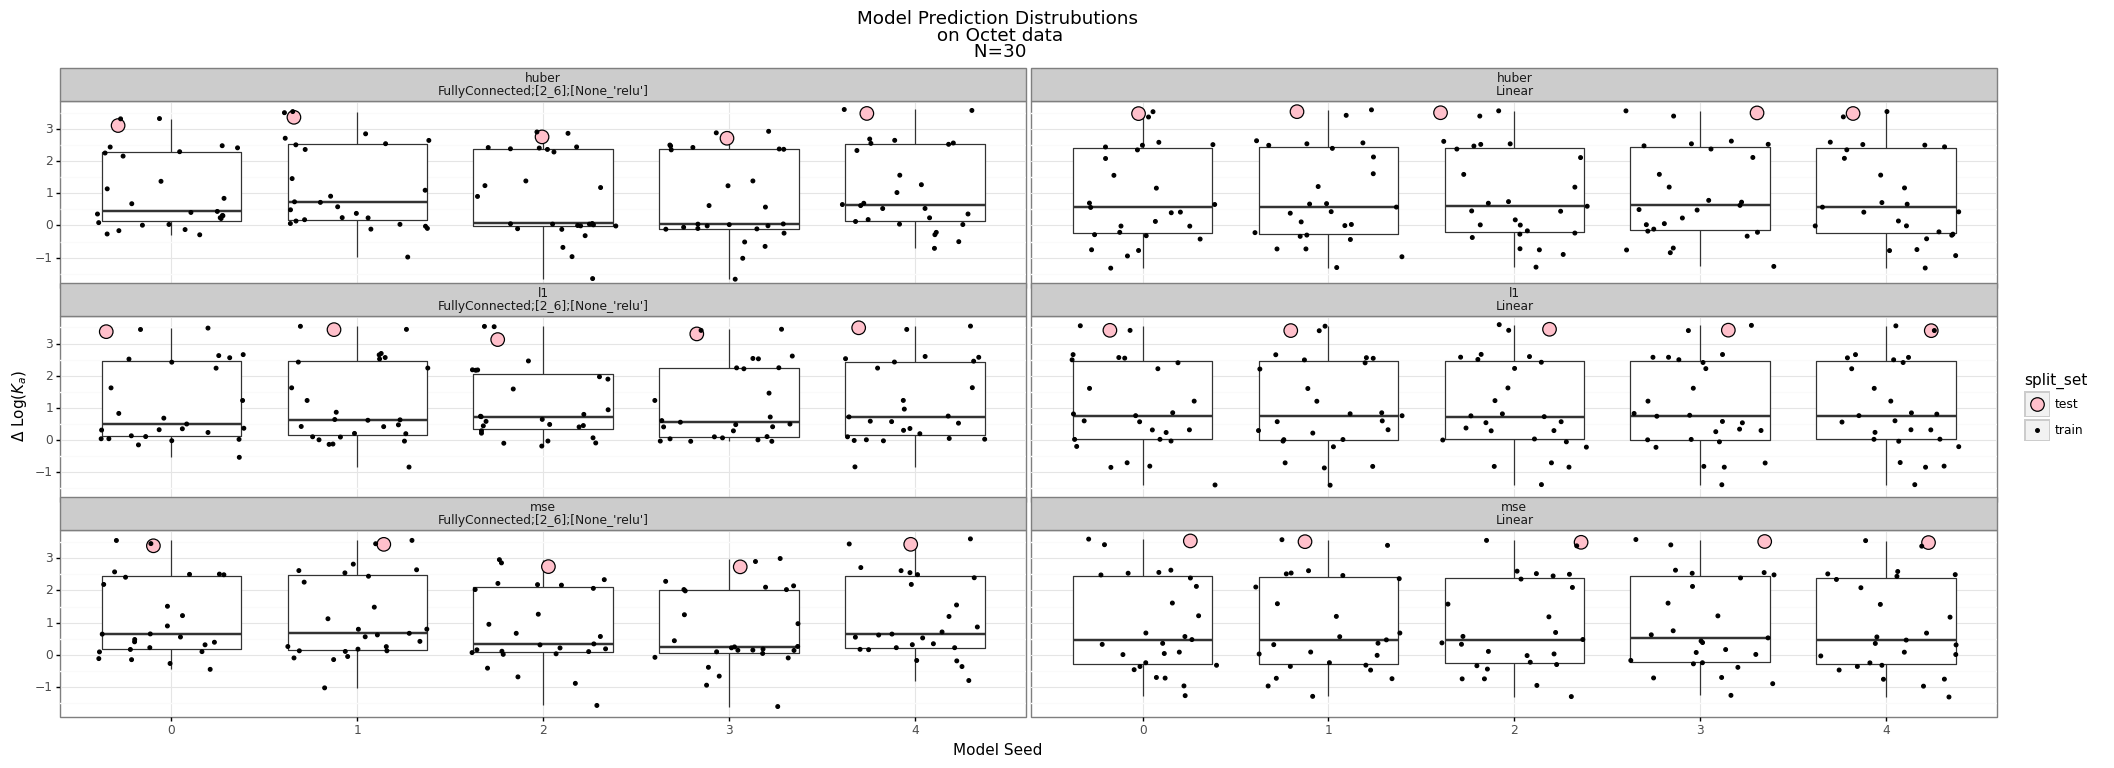

In [164]:
g = (
    ggplot(octet_df_tall)

    + geom_boxplot(
        aes(
            group="factor(model_id)",
            x="seed", 
            y="pred_delta_bind",
        ),
        show_legend=False
    )
    + geom_jitter(
        aes(
            group="factor(model_id)",
            x="seed", 
            y="pred_delta_bind",
            fill="split_set",
            size="split_set"
        ),
        show_legend=True
    )
    + facet_wrap(
        "~ loss_fn + model_string",
        ncol=2,
        scales = 'free_x'
    )
    + theme_bw()
    + theme(
        figure_size = (25, 8),
        subplots_adjust = {
            "hspace": 0.15,
            "wspace": 0.005
        },
    )
    + labs(
        title=f"Model Prediction Distrubutions\n on Octet data\n N={len(model_df)}",
        x = "Model Seed",
        y = "$\Delta$ Log($K_{a}$)"
    )
    + scale_fill_manual(
        {
            "test" : "pink",
            "train" : "black"
        }
    )
    + scale_size_manual (
        {
            "test" : 5,
            "train" : 1
        }
    )
)
_ = g.draw()

In [165]:
from datetime import date

In [166]:
g.save(f"boxplot-seed-replicate-octet-predictions.png")

## Held out test data (predicting from raw)

In [167]:
held_out_df = final_multi_variant_scores.query("split_set == 'test'").reset_index().copy()
id_vars = ["aa_sequence", "n_aa_substitutions","aa_substitutions_IMGT", "aa_substitutions", "delta_bind", "split_set"]
held_out_df = held_out_df[id_vars]
held_out_df

,aa_sequence,n_aa_substitutions,aa_substitutions_IMGT,aa_substitutions,delta_bind,split_set
0,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,2,A100(H)T T5(L)L,A91T T132L,-1.120389,test
1,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,2,A105(H)T D107(H)S,A96T D98S,-0.583298,test
2,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,2,C23(L)W E97(L)C,C150W E208C,-1.318972,test
3,EVQLQESGPSLVKPSQTLSLTHSVTGDSITSGYWNWIRKFPGNKLE...,3,C23(H)H S7(L)R G16(L)P,C22H S134R G143P,NaN,test
4,EVQLQESGPSLVKPSQTLSLTNSVTGDTITSGYWNWIRKFPGNKLE...,3,C23(H)N S29(H)T I126(L)T,C22N S28T I233T,-1.070922,test
...,...,...,...,...,...,...
95,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGSWNWIRKFPGNKLE...,3,Y38(H)S Q90(H)K N28(L)G,Y33S Q81K N155G,-4.059937,test
96,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,2,Y67(H)C P50(L)F,Y59C P171F,0.086404,test
97,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,2,Y87(H)S K24(L)R,Y78S K151R,-2.735464,test
98,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,2,Y103(H)C S26(L)C,Y94C S153C,-0.790973,test


In [168]:
model_pred = {}
for idx, row in model_df.iterrows():
    model_pred[row.model_id] = [
        row.model(row.model.seq_to_binary("".join(aa_seq))).detach().numpy()[0]
        for aa_seq in held_out_df.aa_sequence.values
    ]
model_pred_df = pd.DataFrame(model_pred).astype(float)
assert len(model_pred_df) == len(held_out_df)
model_pred_df

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-1.011717,-1.023866,-0.973727,-0.973056,-0.992452,-0.628119,-1.389314,-1.507388,-0.552905,-1.280597,...,-0.982361,-1.009478,-1.006773,-0.976544,-0.976491,-0.720616,-0.941021,-1.065470,-0.712867,-1.083223
1,-3.149877,-3.131877,-2.937268,-3.185917,-3.043082,-3.458486,-1.340658,-1.173187,-3.230817,-1.024413,...,-3.217485,-3.219909,-3.184258,-3.339667,-2.877662,-3.597378,-0.624629,-0.443883,-3.191698,-0.361591
2,-0.678566,-0.669109,-0.603558,-0.644376,-0.636881,-0.298909,-1.550175,-1.508545,-0.160947,-1.133486,...,-0.734257,-0.750299,-0.745256,-0.718369,-0.684939,-0.437160,-0.916006,-1.116576,-0.414695,-1.033498
3,-0.504076,-0.489446,-0.430345,-0.501594,-0.474770,-1.110942,-1.848595,-1.656228,-0.961625,-1.486958,...,-0.583308,-0.591035,-0.595091,-0.631305,-0.518095,-1.080791,-1.244666,-1.261002,-1.140096,-1.156374
4,-0.072428,-0.068730,0.049691,-0.068710,-0.011755,-0.834934,-2.046427,-2.102794,-0.648356,-1.697366,...,-0.144002,-0.161480,-0.150822,-0.193997,-0.039444,-0.890082,-1.500497,-1.599249,-0.858783,-1.440378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-2.680554,-2.642905,-2.408584,-2.742649,-2.507600,-3.675495,-0.957238,-1.024628,-3.473907,-0.807121,...,-2.781484,-2.733411,-2.671532,-3.105589,-2.125852,-3.929012,-0.733036,-0.507330,-2.475258,-0.391435
96,-0.084819,-0.107093,-0.067358,-0.050446,-0.074111,-0.260871,-0.217167,-0.298045,-0.281280,-0.258406,...,-0.107828,-0.144388,-0.143148,-0.092608,-0.126704,-0.235993,-0.538431,-0.391495,-0.343353,-0.319761
97,-2.111502,-2.115957,-2.024950,-2.093519,-2.055717,-2.286861,-0.954449,-1.005799,-1.693021,-0.670658,...,-2.079913,-2.073414,-2.049207,-2.226805,-1.798827,-2.502048,-0.613465,-0.512662,-0.938913,-0.377493
98,0.167809,0.152361,0.203131,0.190893,0.185141,-0.418492,-0.739274,-0.857498,-0.358890,-0.990422,...,0.149802,0.121669,0.116310,0.143789,0.166469,-0.506276,-0.742164,-0.735467,-0.356100,-0.775063


In [169]:
held_out_df_tall = (
held_out_df.join(model_pred_df)
    .melt(id_vars=id_vars, var_name="model_id", value_name="pred_delta_bind")
    .merge(model_df, on="model_id", how="outer")
)
held_out_df_tall

,aa_sequence,n_aa_substitutions,aa_substitutions_IMGT,aa_substitutions,delta_bind,split_set,model_id,pred_delta_bind,model_name,model,loss_fn,model_string,seed
0,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,2,A100(H)T T5(L)L,A91T T132L,-1.120389,test,0,-1.011717,CGG-bind-stab-poly.model,Linear(\n (latent_layer): Linear(in_features=...,mse,Linear,2
1,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,2,A105(H)T D107(H)S,A96T D98S,-0.583298,test,0,-3.149877,CGG-bind-stab-poly.model,Linear(\n (latent_layer): Linear(in_features=...,mse,Linear,2
2,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,2,C23(L)W E97(L)C,C150W E208C,-1.318972,test,0,-0.678566,CGG-bind-stab-poly.model,Linear(\n (latent_layer): Linear(in_features=...,mse,Linear,2
3,EVQLQESGPSLVKPSQTLSLTHSVTGDSITSGYWNWIRKFPGNKLE...,3,C23(H)H S7(L)R G16(L)P,C22H S134R G143P,NaN,test,0,-0.504076,CGG-bind-stab-poly.model,Linear(\n (latent_layer): Linear(in_features=...,mse,Linear,2
4,EVQLQESGPSLVKPSQTLSLTNSVTGDTITSGYWNWIRKFPGNKLE...,3,C23(H)N S29(H)T I126(L)T,C22N S28T I233T,-1.070922,test,0,-0.072428,CGG-bind-stab-poly.model,Linear(\n (latent_layer): Linear(in_features=...,mse,Linear,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGSWNWIRKFPGNKLE...,3,Y38(H)S Q90(H)K N28(L)G,Y33S Q81K N155G,-4.059937,test,29,-0.391435,CGG-bind-stab-poly.model,FullyConnected(\n (latent_layer): Linear(in_f...,huber,FullyConnected;[2_6];[None_'relu'],1
2996,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,2,Y67(H)C P50(L)F,Y59C P171F,0.086404,test,29,-0.319761,CGG-bind-stab-poly.model,FullyConnected(\n (latent_layer): Linear(in_f...,huber,FullyConnected;[2_6];[None_'relu'],1
2997,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,2,Y87(H)S K24(L)R,Y78S K151R,-2.735464,test,29,-0.377493,CGG-bind-stab-poly.model,FullyConnected(\n (latent_layer): Linear(in_f...,huber,FullyConnected;[2_6];[None_'relu'],1
2998,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,2,Y103(H)C S26(L)C,Y94C S153C,-0.790973,test,29,-0.775063,CGG-bind-stab-poly.model,FullyConnected(\n (latent_layer): Linear(in_f...,huber,FullyConnected;[2_6];[None_'relu'],1


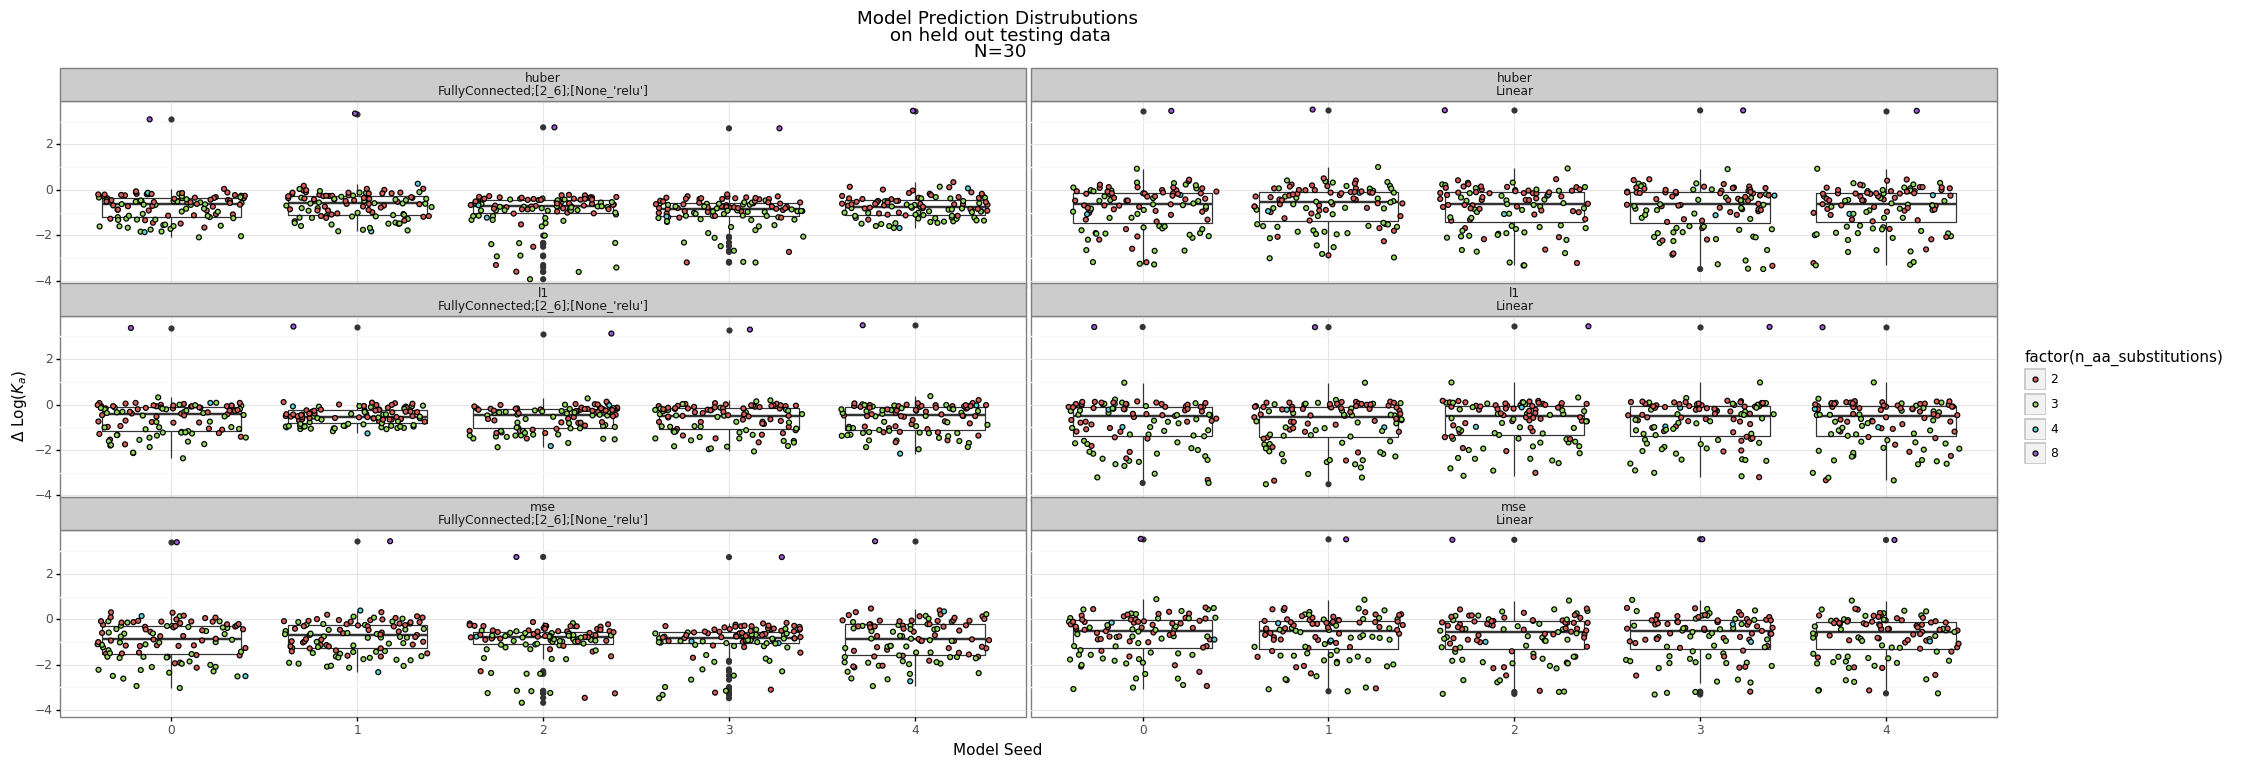

In [170]:
g = (
    ggplot(held_out_df_tall)

    + geom_boxplot(
        aes(
            group="factor(model_id)",
            x="seed", 
            y="pred_delta_bind",
        ),
        show_legend=False
    )
    + geom_jitter(
        aes(
            group="factor(model_id)",
            x="seed", 
            y="pred_delta_bind",
            fill="factor(n_aa_substitutions)",
#             fill="factor(library)",
#             size="factor()"
        ),
        show_legend=True
    )
    + facet_wrap(
        "~ loss_fn + model_string",
        ncol=2,
        scales = 'free_x'
    )
    + theme_bw()
    + theme(
        figure_size = (25, 8),
        subplots_adjust = {
            "hspace": 0.15,
            "wspace": 0.005
        },
    )
    + labs(
        title=f"Model Prediction Distrubutions\n on held out testing data\n N={len(model_df)}",
        x = "Model Seed",
        y = "$\Delta$ Log($K_{a}$)"
    )
)
_ = g.draw()

In [171]:
g.save(f"boxplot-seed-replicate-held-out-predictions.png")

## Model Accuracy

In [172]:
# calculate octet accuracy
model_df = model_df.assign(octet_pred_corr = 0)
for model_id, octet_model_preds in octet_df_tall.groupby("model_id"):
    y_yhat = octet_model_preds[["delta_bind", "pred_delta_bind"]].dropna()
    corr = sp.pearsonr(y_yhat.delta_bind, y_yhat.pred_delta_bind)[0] 
    model_df.loc[model_id, "octet_pred_corr"] = corr

# calculate held out accuracy
model_df = model_df.assign(held_out_pred_corr = 0)
for model_id, held_out_model_preds in held_out_df_tall.groupby("model_id"):
    y_yhat = held_out_model_preds[["delta_bind", "pred_delta_bind"]].dropna()
    corr = sp.pearsonr(y_yhat.delta_bind, y_yhat.pred_delta_bind)[0]
    model_df.loc[model_id, "held_out_pred_corr"] = corr

In [173]:
model_df

,model_name,model,loss_fn,model_string,seed,model_id,octet_pred_corr,held_out_pred_corr
0,CGG-bind-stab-poly.model,Linear(\n (latent_layer): Linear(in_features=...,mse,Linear,2,0,0.988719,0.787359
1,CGG-bind-stab-poly.model,Linear(\n (latent_layer): Linear(in_features=...,mse,Linear,4,1,0.988523,0.787718
2,CGG-bind-stab-poly.model,Linear(\n (latent_layer): Linear(in_features=...,mse,Linear,0,2,0.987606,0.785859
3,CGG-bind-stab-poly.model,Linear(\n (latent_layer): Linear(in_features=...,mse,Linear,3,3,0.989137,0.788176
4,CGG-bind-stab-poly.model,Linear(\n (latent_layer): Linear(in_features=...,mse,Linear,1,4,0.988137,0.785701
5,CGG-bind-stab-poly.model,FullyConnected(\n (latent_layer): Linear(in_f...,mse,FullyConnected;[2_6];[None_'relu'],2,5,0.962008,0.765838
6,CGG-bind-stab-poly.model,FullyConnected(\n (latent_layer): Linear(in_f...,mse,FullyConnected;[2_6];[None_'relu'],4,6,0.981896,0.651826
7,CGG-bind-stab-poly.model,FullyConnected(\n (latent_layer): Linear(in_f...,mse,FullyConnected;[2_6];[None_'relu'],0,7,0.977836,0.639964
8,CGG-bind-stab-poly.model,FullyConnected(\n (latent_layer): Linear(in_f...,mse,FullyConnected;[2_6];[None_'relu'],3,8,0.961036,0.714899
9,CGG-bind-stab-poly.model,FullyConnected(\n (latent_layer): Linear(in_f...,mse,FullyConnected;[2_6];[None_'relu'],1,9,0.974904,0.616733


In [174]:
for model_type, models in model_df.groupby("model_string"):
    max_oct_corr = max(models.octet_pred_corr.values)
    max_ho_corr = max(models.held_out_pred_corr.values)
    print(models.query(f"held_out_pred_corr == {max_ho_corr}").index.values)
    print(f"Max Oct for {model_type} is {round(max_oct_corr,3)}")
    print(f"Max Held Out corr for {model_type} is {round(max_ho_corr,3)}")    

[25]
Max Oct for FullyConnected;[2_6];[None_'relu'] is 0.983
Max Held Out corr for FullyConnected;[2_6];[None_'relu'] is 0.772
[12]
Max Oct for Linear is 0.99
Max Held Out corr for Linear is 0.803


In [175]:
model_df.loc[[28, 10], :]

,model_name,model,loss_fn,model_string,seed,model_id,octet_pred_corr,held_out_pred_corr
28,CGG-bind-stab-poly.model,FullyConnected(\n (latent_layer): Linear(in_f...,huber,FullyConnected;[2_6];[None_'relu'],3,28,0.949146,0.723697
10,CGG-bind-stab-poly.model,Linear(\n (latent_layer): Linear(in_features=...,l1,Linear,2,10,0.986837,0.788480


In [176]:
! ls {exp}/_output/loss_fn@l1/model_string@Linear/seed@2/CGG-bind-stab-poly.model

2022-05-22-CGG-bind-stab-poly/_output/loss_fn@l1/model_string@Linear/seed@2/CGG-bind-stab-poly.model


In [177]:
! cp {exp}/_output/loss_fn@l1/model_string@Linear/seed@2/CGG-bind-stab-poly.model {prepped_dir}/tdms-linear.model

In [178]:
! ls {exp}/_output/loss_fn@huber/'model_string@FullyConnected;[2_6];[None_'\''relu'\'']'/seed@3/CGG-bind-stab-poly.model

'2022-05-22-CGG-bind-stab-poly/_output/loss_fn@huber/model_string@FullyConnected;[2_6];[None_'\''relu'\'']/seed@3/CGG-bind-stab-poly.model'


In [179]:
! cp '2022-05-22-CGG-bind-stab-poly/_output/loss_fn@huber/model_string@FullyConnected;[2_6];[None_'\''relu'\'']/seed@3/CGG-bind-stab-poly.model' {prepped_dir}/tdms-fully-connected.model

In [180]:
! ls {prepped_dir}

dms-octet-cali	    final-multi-variant-scores.csv  tdms-linear.model
dms-octet-cali.pkl  tdms-fully-connected.model
